# Natality project: predictive analysis 


## 1. Load and prepare the data
The dataset underwent the following changes:
- We removed the variables not used for prediction, and missing values for the dependent variable
- Categorical variables were dummified
- Numeric variables mistakenly saved as floats were changed to integers
- Interval since last pregnancy was log transformed then split in bins to be a categorical variable
- Prepregnancy weight was log transformed

In [1]:
# Load packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import sklearn
import seaborn as sns
from pandas_profiling import ProfileReport
import statsmodels as sm
%matplotlib inline

In [2]:
# Load dataset
data = pd.read_csv('data/df_42_imputed.csv', index_col=0)
data.head()

C:\Users\beren\anaconda3\envs\TensorFlow-GPU\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,birth_month,birth_time,birth_weekday,birth_place,mother_age,mother_nativity,mother_race,mother_hispanic,paternity_acknowledged,mother_education,...,no_maternal_morbidity,payment,plural_birth,sex,gestation_week,obstetric_estimate,birth_weight,no_abnormal_condition,no_congenital_anomalies,breastfed
1,1,1227.0,2,1,30,1,1,0,X,6,...,1,2,1,M,38.0,40.0,3657.0,1,1,Y
2,1,336.0,2,1,28,1,1,0,X,6,...,1,4,1,M,37.0,36.0,3470.0,1,1,Y
3,1,938.0,2,1,23,1,3,0,Y,2,...,1,1,1,F,31.0,39.0,3140.0,1,1,N
4,1,28.0,2,2,26,1,1,0,X,6,...,1,2,1,F,40.0,39.0,4082.0,1,1,Y
5,1,1615.0,4,1,31,1,1,0,X,3,...,1,2,1,F,40.0,40.0,3230.0,1,1,Y


In [3]:
#Remove columns not used for prediction:  
data.drop(['induction', 'father_age','BMI','birth_weekday','number_prenatal_visits', 'delivery_method', 'breastfed', 
           'no_abnormal_condition', 'no_maternal_morbidity', 'birth_weight', 'birth_time', 'delivery_weight', 
           'labor_trial', 'no_congenital_anomalies', 'gestation_week'], inplace=True, axis =1)
data.shape

(1921127, 27)

In [4]:
categorical = ['birth_month', 'birth_place', 'mother_nativity', 'mother_race', 'mother_hispanic', 'paternity_acknowledged',
               'mother_education', 'father_race', 'father_hispanic', 'father_education', 'WIC', 'tobacco', 
               'previous_preterm_birth', 'infertility_treatment','no_risk_factors', 'no_infection',
                'payment', 'sex']
data[categorical] = data[categorical].astype(str)

In [5]:
#Remove missing values for the dependant variable
df_clean = data[data.obstetric_estimate.notna()].reset_index(drop=True)

In [6]:
#Check 
ProfileReport(df_clean)

C:\Users\beren\anaconda3\envs\TensorFlow-GPU\lib\site-packages\pandas_profiling\describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,27
Number of observations,1919518
Total Missing (%),0.0%
Total size in memory,395.4 MiB
Average record size in memory,216.0 B
Numeric,9
Categorical,18
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [7]:
# Make dummy variable for all categorical variables
for var in categorical:
    dummy = pd.get_dummies(df_clean[str(var)])
    col_dict = {}
    for i in dummy.columns:
        col_dict[i] = str(var) + "-" + str(i)
    dummy = dummy.rename(columns=col_dict)
    dummy = dummy.drop(columns=dummy.columns[0])
    df_clean = pd.concat([df_clean, dummy], axis = 1)
    df_clean = df_clean.drop(var, axis =1)
df_clean.head()

,mother_age,total_birth_order,interval_since_last_pregnancy,month_prenatal_care_began,mother_height,prepregnancy_weight,previous_cesareans,plural_birth,obstetric_estimate,birth_month-10,...,WIC-Y,tobacco-Y,previous_preterm_birth-Y,infertility_treatment-Y,no_risk_factors-1,no_infection-1,payment-2,payment-3,payment-4,sex-M
0,30,4.0,16.000000,3.0,66.0,190.0,0,1,40.0,0,...,0,0,0,0,1,1,1,0,0,1
1,28,2.0,210.034575,5.0,71.0,215.0,0,1,36.0,0,...,1,0,0,0,0,1,0,0,1,1
2,23,3.0,43.000000,5.0,64.0,138.0,0,1,39.0,0,...,0,0,0,0,1,1,0,0,0,0
3,26,2.0,39.000000,2.0,67.0,200.0,0,1,39.0,0,...,0,0,0,0,1,1,1,0,0,0
4,31,1.0,888.000000,3.0,67.0,180.0,0,1,40.0,0,...,0,0,0,0,1,1,1,0,0,0


In [8]:
#df_clean = df_clean.dropna()
numeric = ['mother_age','total_birth_order', 'month_prenatal_care_began', 'mother_height', 
           'prepregnancy_weight', 'previous_cesareans', 'plural_birth', 'obstetric_estimate' ]
for item in numeric:
    df_clean[item] = df_clean[item].astype(int)

In [9]:
df_clean.dtypes

mother_age                         int32
total_birth_order                  int32
interval_since_last_pregnancy    float64
month_prenatal_care_began          int32
mother_height                      int32
                                  ...   
no_infection-1                     uint8
payment-2                          uint8
payment-3                          uint8
payment-4                          uint8
sex-M                              uint8
Length: 79, dtype: object

Variable 'interval since last pregnancy' is coded 888 for 'no previous child'. We are going to split it into categories. We immediately create columns for dummy variables.
In addition, the distribution is skewed and we want to use the log of the interval so our categories are more balanced (normally distributed).

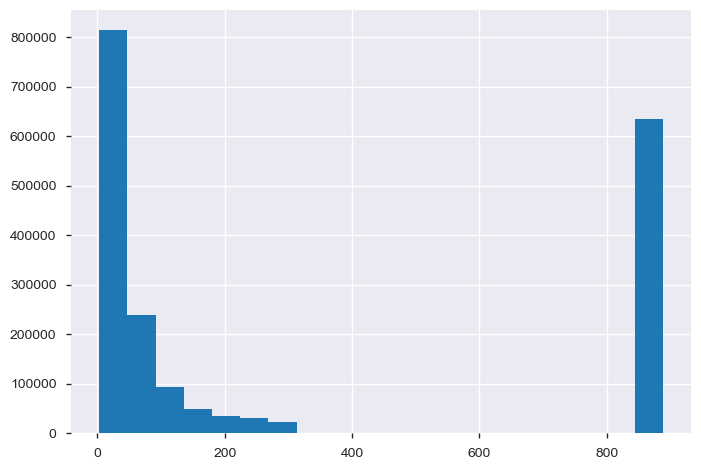

In [10]:
# Check the distribution before transforming - if we make bins now the data won't be spread into bins
plt.hist(df_clean.interval_since_last_pregnancy, 20)
plt.show()

(array([ 29440.,   3731.,  85855., 175633., 317565., 238454., 172176.,
        120981.,  80070.,  61153.,      0., 634460.]),
 array([1.09861229, 1.57280891, 2.04700553, 2.52120215, 2.99539877,
        3.46959539, 3.94379202, 4.41798864, 4.89218526, 5.36638188,
        5.8405785 , 6.31477512, 6.78897174]),
 <a list of 12 Patch objects>)

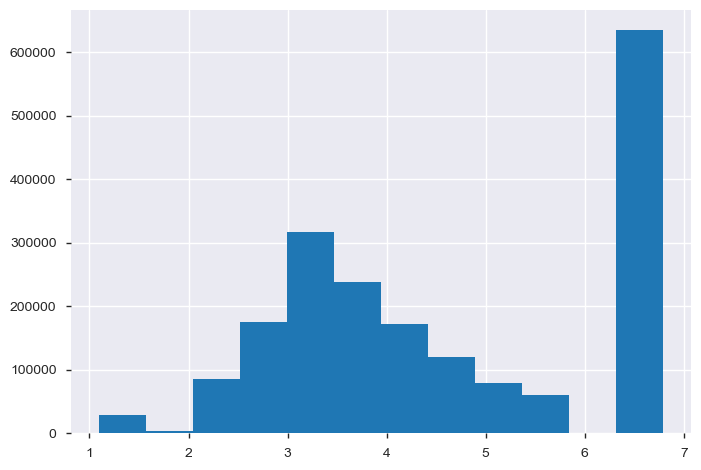

In [11]:
#Create a column with the log of the interval and check if distribution is normal
df_clean['interval_since_last_pregnancy_log'] = np.log(df_clean.interval_since_last_pregnancy)
plt.hist(df_clean.interval_since_last_pregnancy_log, 12)

Once we take the log of the interval, the distribution is normal (data coded 888 are first time mothers, in other words cases for which interval since last pregnancy is not applicable)

In [12]:
#Use the array to split into 10 categories (from 12: for dummy variables, we need n-1 columns. Column 11 is 
#the one we remove.  Column 10 did not comatin any records)
histogram_limits = [1.09861229, 1.57280891, 2.04700553, 2.52120215, 2.99539877,
        3.46959539, 3.94379202, 4.41798864, 4.89218526, 5.36638188,
        5.8405785 , 6.31477512, 6.78897174]

for i in range(0, len(histogram_limits)-3):
    df_clean['interval-'+str(i)] = df_clean.interval_since_last_pregnancy_log.between(histogram_limits[i], histogram_limits[i+1])
        

In [13]:
# Remove unnecessary columns
df_clean.drop([ 'interval_since_last_pregnancy', 'interval_since_last_pregnancy_log'], inplace=True, axis =1)


(array([2.00000e+00, 2.00000e+00, 2.72000e+02, 1.47900e+03, 9.51400e+03,
        5.07030e+04, 1.34110e+05, 2.93195e+05, 3.99708e+05, 3.26678e+05,
        2.51092e+05, 1.97433e+05, 1.12987e+05, 7.47900e+04, 4.02940e+04,
        1.78660e+04, 6.42200e+03, 2.20300e+03, 7.59000e+02, 9.00000e+00]),
 array([4.00733319, 4.11164501, 4.21595684, 4.32026867, 4.4245805 ,
        4.52889233, 4.63320416, 4.73751599, 4.84182782, 4.94613965,
        5.05045148, 5.15476331, 5.25907514, 5.36338697, 5.46769879,
        5.57201062, 5.67632245, 5.78063428, 5.88494611, 5.98925794,
        6.09356977]),
 <a list of 20 Patch objects>)

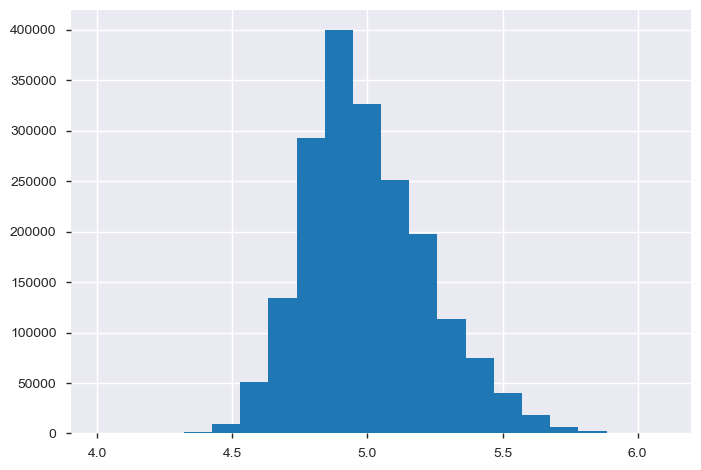

In [14]:
df_clean.prepregnancy_weight = np.log(df_clean.prepregnancy_weight)
plt.hist(df_clean.prepregnancy_weight, 20)

In [15]:
print(df_clean.dtypes)

mother_age                     int32
total_birth_order              int32
month_prenatal_care_began      int32
mother_height                  int32
prepregnancy_weight          float64
                              ...   
interval-5                      bool
interval-6                      bool
interval-7                      bool
interval-8                      bool
interval-9                      bool
Length: 88, dtype: object


In [16]:
df_clean.to_csv('data/df_dummy_var_log_transfo.csv', index=False)
#df = pd.read_csv('data/df_dummy_var_log_transfo.csv')

Finally, we split the dataset into train and test sets:

In [17]:
# Split the data set into train and test sets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
X = df_clean.drop(['obstetric_estimate'], axis = 1)
y = df_clean.obstetric_estimate

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state= 2)

## 2. Linear regressions

### Scikit-learn Linear Regression - OLS###

In [18]:
# Create a LinearRegression object
lm = LinearRegression()

In [19]:
# Fit the model
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [20]:
# Make predictions on test data
predictions = lm.predict(X_test)
# Performance metrics
errors = abs(round(predictions - y_test, 0))
print('Average absolute error:', round(np.mean(errors), 2), 'weeks.')
good_pred = errors[errors == 0].count()
print('Percent of correct predictions:', round(good_pred/errors.shape[0], 2)*100,  '%.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Average absolute error: 1.15 weeks.
Percent of correct predictions: 31.0 %.
Accuracy: 96.79 %.


In [21]:
# Intercept and R^2
print('Estimated intercept coefficient: {}'.format(round(lm.intercept_), 4))
R2train = lm.score(X_train, y_train)
print('R2 train is :', round(R2train, 4))
R2test = lm.score(X_test, y_test)
print('R2 test is :', round(R2test, 4))
n = X_train.shape[0]
p = X_train.shape[1]
adj_R2 = 1-(1-R2train)*(n-1)/(n-p-1)
print('Adjusted R2 is :', round(adj_R2, 4))

Estimated intercept coefficient: 40.0
R2 train is : 0.1211
R2 test is : 0.1238
Adjusted R2 is : 0.1211


The intercept indicates that 40 weeks (out of roughly 40) are explained by a constant rather than our variables. This indicates that a linear model might not be suitable for this dataset. $R^2$ is terrible as well, just 12\% better than a random distribution.

Text(0.5, 1.0, 'Relationship between Predicted and Actual delivery week (test set)')

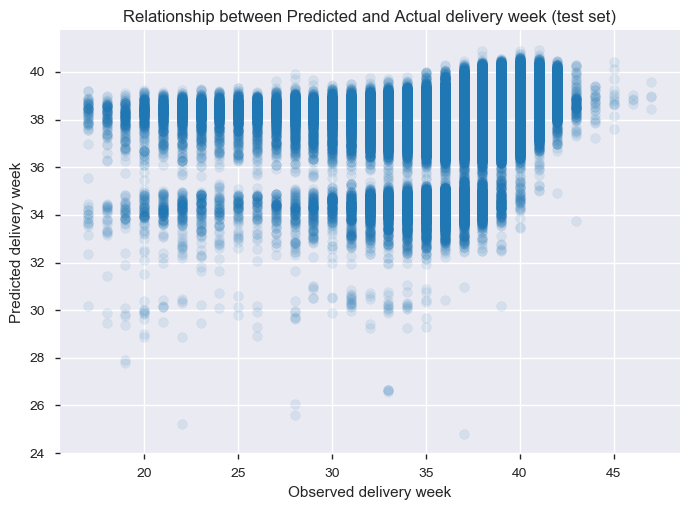

In [22]:
# Plot observed vs predicted delivery week (test set)
plt.scatter(y_test, lm.predict(X_test), alpha = 0.1)
plt.xlabel("Observed delivery week")
plt.ylabel("Predicted delivery week")
plt.title("Relationship between Predicted and Actual delivery week (test set)")

This plot indicates that there are a lot of wrong predictions for premature babies: most of the predicted values are around 34 or 36 weeks where the birth occured anywhere between 18 and 45 weeks!
This model is terrible at predicting delivery week.
Although the average absolute error is not too high, and the accuracy appears to be good, the way they are calculated doesn't give a representative idea of how good the model is. More on this later.

In [23]:
#Pearson coefficient
ols_pearsonr = stats.pearsonr(y_test, predictions)[0]
print("Pearson coefficient is:", round(ols_pearsonr, 3))

Pearson coefficient is: 0.352


Text(0.5, 1.0, 'Relationship between $\\hatY$ and the residuals')

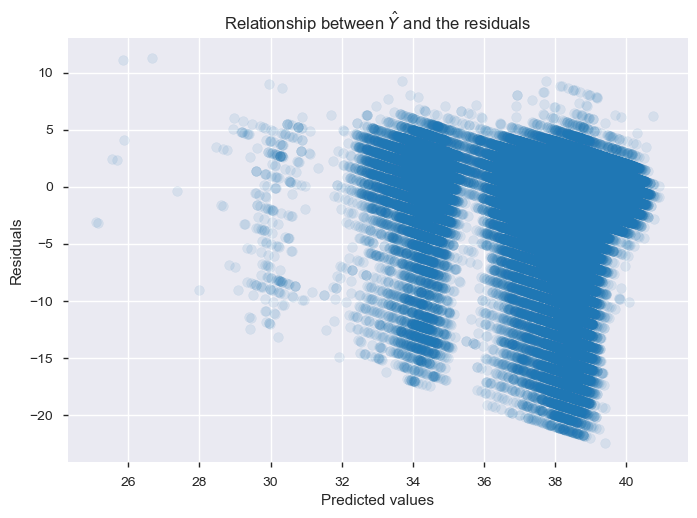

In [24]:
#Distribution of the residuals
plt.scatter(lm.predict(X_train), (y_train - lm.predict(X_train)), alpha = 0.1)
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Relationship between $\hatY$ and the residuals")

There should be no pattern when plotting the fitted values vs. residuals, and there are three clusters (at 30, 34 and 36 weeks as already observed in the previous plot).
In addition, we observe more extreme residuals in the negative values (bottom half, below Residuals = 0), indicating that the model often predicts too high of a value. 

### Ridge regression###

In [25]:
from sklearn.linear_model import Ridge

# Creates a Ridge object
rm = Ridge()
# Train the model
rm.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [26]:
# Make predictions on test data
predictions = rm.predict(X_test)
# Performance metrics
errors = abs(round(predictions - y_test, 0))
print('Average absolute error:', round(np.mean(errors), 2), 'weeks.')
print('Standard deviation of absolute error:', round(np.std(errors), 2), 'weeks.')
good_pred = errors[errors == 0].count()
print('Percent of correct predictions:', round(good_pred/errors.shape[0], 2)*100,  '%.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Average absolute error: 1.15 weeks.
Standard deviation of absolute error: 1.54 weeks.
Percent of correct predictions: 31.0 %.
Accuracy: 96.79 %.


Text(0.5, 1.0, 'Relationship between Predicted and Actual delivery week')

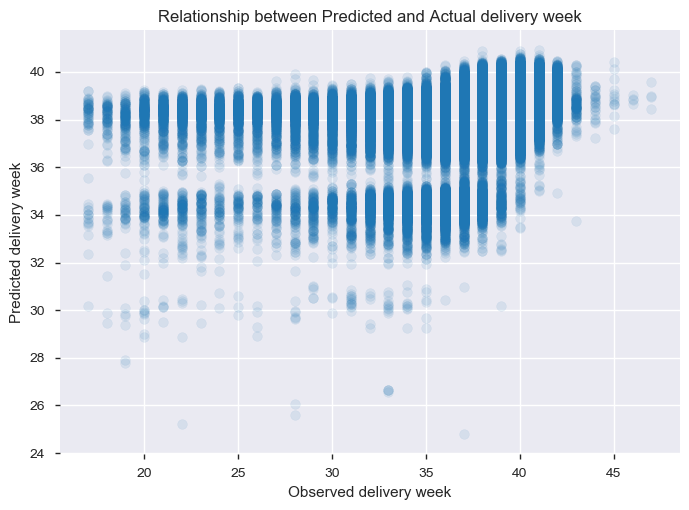

In [27]:
# Plot observed vs predicted delivery week
plt.scatter(y_test, predictions, alpha =0.1)
plt.xlabel("Observed delivery week")
plt.ylabel("Predicted delivery week")
plt.title("Relationship between Predicted and Actual delivery week")

In [28]:
# The intercept and R2
print('Estimated intercept coefficient: {}'.format(round(rm.intercept_), 4))
R2 = rm.score(X_test, y_test)
print('R2 is :', round(R2, 4))
n = X_train.shape[0]
p = X_train.shape[1]
adj_R2 = 1-(1-R2)*(n-1)/(n-p-1)
print('Adjusted R2 is :', round(adj_R2, 4))

Estimated intercept coefficient: 40.0
R2 is : 0.1238
Adjusted R2 is : 0.1238


This $R^2$ score is the same as the OLS regression

In [29]:
#Pearson coefficient (indicates correlation)
ridge_pearsonr = stats.pearsonr(y_test, predictions)[0]
print("Pearson coefficient is:", round(ridge_pearsonr, 4))

Pearson coefficient is: 0.3519


Text(0.5, 1.0, 'Relationship between $\\hatY$ and the residuals')

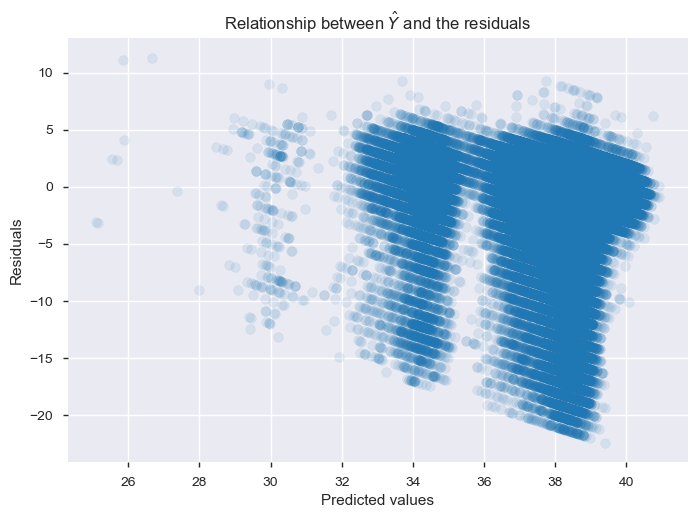

In [30]:
#Distribution of the residuals
plt.scatter(rm.predict(X_train), (y_train - rm.predict(X_train)), alpha = 0.1)
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Relationship between $\hatY$ and the residuals")

Using a standard Ridge regression did not improve the model. We can try to tune alpha

In [31]:
from sklearn.model_selection import GridSearchCV 
param_grid = {'alpha': (0.01, 0.1, 1, 10, 100)} 
clf = Ridge()
clf_cv = GridSearchCV(clf, param_grid, cv=5) 
clf_cv.fit(X_train, y_train)
clf_cv.best_params_

{'alpha': 10}

In [32]:
# Creates a Ridge object
rm2 = Ridge(alpha = 10)
# Train the Ridge object
rm2.fit(X_train, y_train)

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [33]:
# The intercept and R2
print('Estimated intercept coefficient: {}'.format(round(rm2.intercept_), 4))
R2 = rm2.score(X_test, y_test)
print('R2 is :', round(R2, 4))
n = X_train.shape[0]
p = X_train.shape[1]
adj_R2 = 1-(1-R2)*(n-1)/(n-p-1)
print('Adjusted R2 is :', round(adj_R2, 4))

Estimated intercept coefficient: 40.0
R2 is : 0.1238
Adjusted R2 is : 0.1238


In [34]:
# Make predictions on test data
predictions = rm2.predict(X_test)
# Performance metrics
errors = abs(round(predictions - y_test, 0))
print('Average absolute error:', round(np.mean(errors), 2), 'weeks.')
print('Standard deviation of absolute error:', round(np.std(errors), 2), 'weeks.')
good_pred = errors[errors == 0].count()
print('Percent of correct predictions:', round(good_pred/errors.shape[0], 2)*100,  '%.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Average absolute error: 1.15 weeks.
Standard deviation of absolute error: 1.54 weeks.
Percent of correct predictions: 31.0 %.
Accuracy: 96.79 %.


Text(0.5, 1.0, 'Relationship between Predicted and Actual delivery week')

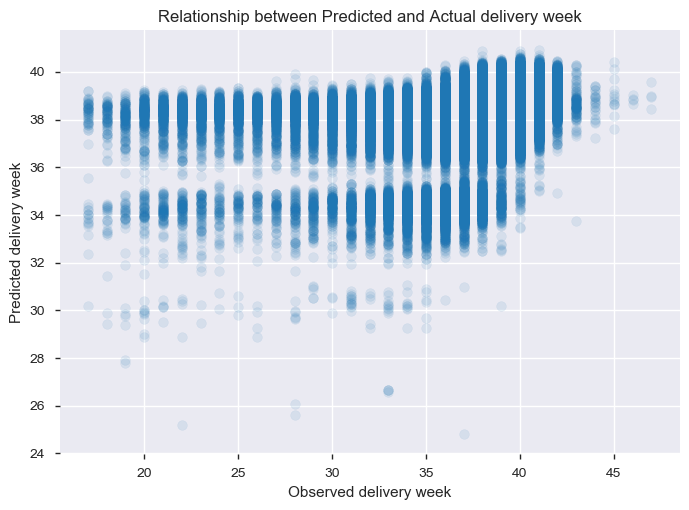

In [35]:
plt.scatter(y_test, rm2.predict(X_test), alpha = 0.1)
plt.xlabel("Observed delivery week")
plt.ylabel("Predicted delivery week")
plt.title("Relationship between Predicted and Actual delivery week")

In [36]:
# The intercept and R2
print('Estimated intercept coefficient: {}'.format(round(rm2.intercept_), 4))
R2 = rm2.score(X_test, y_test)
print('R2 is :', round(R2, 4))
n = X_train.shape[0]
p = X_train.shape[1]
adj_R2 = 1-(1-R2)*(n-1)/(n-p-1)
print('Adjusted R2 is :', round(adj_R2, 4))

Estimated intercept coefficient: 40.0
R2 is : 0.1238
Adjusted R2 is : 0.1238


Still no improvement, let's move to a different type of models: Support Vector Regressions

## 2. SVR ##

### With linear kernel###

Based on the documentation, for a large dataset, LinearSRV model is recommended.

In [37]:
from sklearn.svm import LinearSVR
# Create SVR object
LSVR = LinearSVR()
#Train the model
LSVR.fit(X_train, y_train)

C:\Users\beren\anaconda3\envs\TensorFlow-GPU\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=None, tol=0.0001, verbose=0)

Text(0.5, 1.0, 'Relationship between Predicted and Actual delivery week')

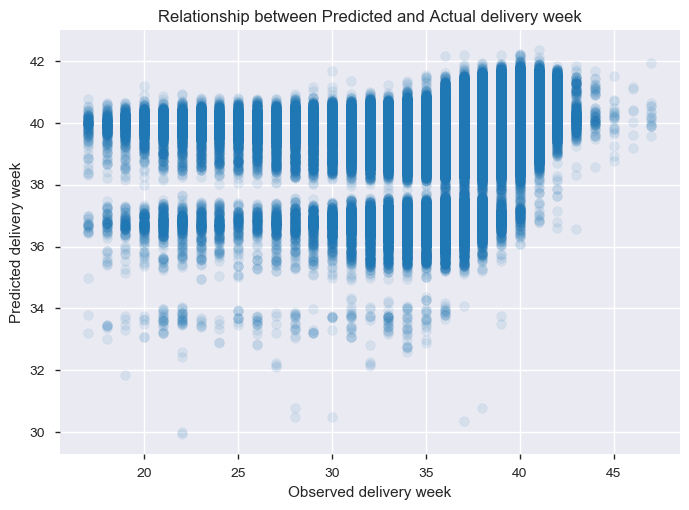

In [38]:
plt.scatter(y_train, LSVR.predict(X_train), alpha = 0.1)
plt.xlabel("Observed delivery week")
plt.ylabel("Predicted delivery week")
plt.title("Relationship between Predicted and Actual delivery week")

In [39]:
# Make predictions on test data
predictions = LSVR.predict(X_test)
# Performance metrics
errors = abs(round(predictions - y_test, 0))
print('Average absolute error:', round(np.mean(errors), 2), 'weeks.')
print('Standard deviation of absolute error:', round(np.std(errors), 2), 'weeks.')
good_pred = errors[errors == 0].count()
print('Percent of correct predictions:', round(good_pred/errors.shape[0], 2)*100,  '%.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Average absolute error: 1.57 weeks.
Standard deviation of absolute error: 1.85 weeks.
Percent of correct predictions: 22.0 %.
Accuracy: 95.58 %.


In [40]:
#R^2
#LSVR.score(X_test, y_test)
R2train = LSVR.score(X_train, y_train)
print('R2train is :', round(R2train, 4))
R2test = LSVR.score(X_test, y_test)
print('R2test is :', round(R2test, 4))
n = X_train.shape[0]
p = X_train.shape[1]
adj_R2 = 1-(1-R2train)*(n-1)/(n-p-1)
print('Adjusted R2 is :', round(adj_R2, 4))



R2train is : -0.4462
R2test is : -0.4441
Adjusted R2 is : -0.4463


Based on the documentation:
The coefficient $R^2$ is defined as $$(1 - u/v)$$ where u is the residual sum of squares ((y_true - y_pred) ** 2).sum() and v is the total sum of squares ((y_true - y_true.mean()) ** 2).sum(). The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a $R^2$ score of 0.0.

Despite this explanation, the $R^2$ value obtained does not make sense

Text(0.5, 1.0, 'Relationship between $\\hatY$ and the residuals')

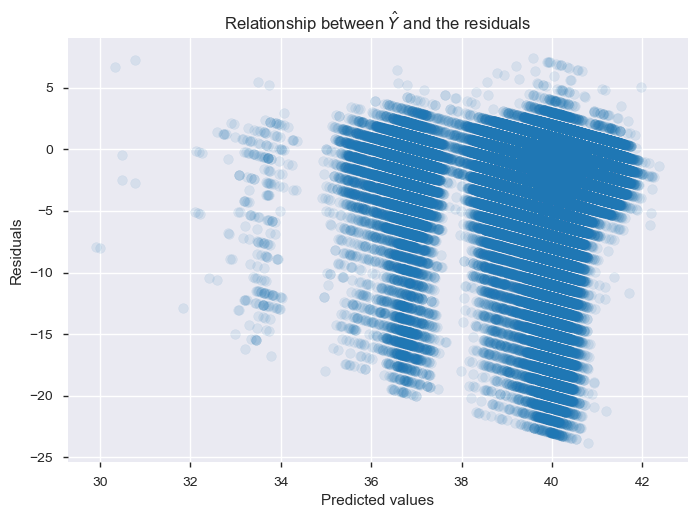

In [41]:
#Distribution of the residuals
plt.scatter(LSVR.predict(X_train), (y_train - LSVR.predict(X_train)), alpha = 0.1)
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Relationship between $\hatY$ and the residuals")

SVR does not seem to be a good model either: the accuracy is lower, and $R^2$ is very similar

## 3. Random forest ##

In [42]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [43]:
# Make predictions on test data
predictions = rf.predict(X_test)
# Performance metrics
errors = abs(round(predictions - y_test, 0))
print('Average absolute error:', round(np.mean(errors), 2), 'weeks.')
print('Standard deviation of absolute error:', round(np.std(errors), 2), 'weeks.')
good_pred = errors[errors == 0].count()
print('Percent of correct predictions:', round(good_pred/errors.shape[0], 2)*100,  '%.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Average absolute error: 1.19 weeks.
Standard deviation of absolute error: 1.53 weeks.
Percent of correct predictions: 30.0 %.
Accuracy: 96.7 %.


Text(0.5, 1.0, 'Relationship between Predicted and Actual delivery week')

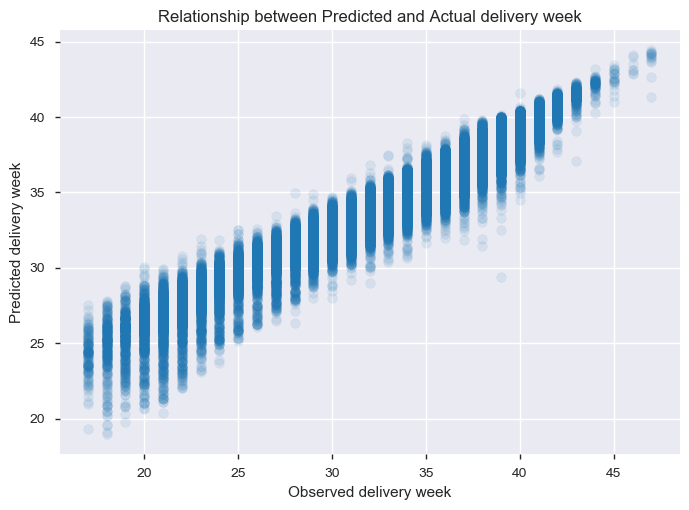

In [45]:
# Plot observed vs predicted values (train set)
plt.scatter(y_train, rf.predict(X_train), alpha = 0.1)
plt.xlabel("Observed delivery week")
plt.ylabel("Predicted delivery week")
plt.title("Relationship between Predicted and Actual delivery week")

In [ ]:
# R2
R2train = rf.score(X_train, y_train)
print('R2train is :', round(R2train, 4))
R2test = rf.score(X_test, y_test)
print('R2test is :', round(R2test, 4))
n = X_train.shape[0]
p = X_train.shape[1]
adj_R2 = 1-(1-R2train)*(n-1)/(n-p-1)
print('Adjusted R2 is :', round(adj_R2, 4))

The accuracy and error are better than previous models, but: 
$$R^2_{\text{test}}\ll R^2_{\text{training}}$$
The model does not generalize well! 

In [ ]:
# Plot observed vs presdicted delivery week ON THE TEST SET
plt.scatter(y_test, predictions, alpha = 0.1)
plt.xlabel("Observed delivery week")
plt.ylabel("Predicted delivery week")
plt.title("Relationship between Predicted and Actual delivery week (test set)")

In [ ]:
#Distribution of the residuals
plt.scatter(rf.predict(X_train), (y_train - rf.predict(X_train)), alpha=0.1)
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Relationship between $\hatY$ and the residuals")

The code below was inspired by a blog post: https://towardsdatascience.com/improving-random-forest-in-python-part-1-893916666cd

In [ ]:
# List of features for later use
feature_list = list(df_clean.columns)
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

In [ ]:
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [ ]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

In [ ]:
# Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)

In [ ]:
# Extract the names of the most important features
important_feature_names = [feature[0] for feature in feature_importances[0:63]]
# Find the columns of the most important features
important_indices = [feature_list.index(feature) for feature in important_feature_names]
# Create training and testing sets with only the important features
important_X_train = X_train.iloc[:, important_indices]
important_X_test = X_test.iloc[:, important_indices]
# Sanity check on operations
print('Important train features shape:', important_X_train.shape)
print('Important test features shape:', important_X_test.shape)

In [ ]:
# Create and train the expanded model on only the important features
rf2 = RandomForestRegressor()
rf2.fit(important_X_train, y_train)

In [ ]:
# R2
R2train = rf2.score(important_X_train, y_train)
print('R2train is :', round(R2train, 4))
R2test = rf2.score(important_X_test, y_test)
print('R2test is :', round(R2test, 4))
n = important_X_train.shape[0]
p = important_X_train.shape[1]
adj_R2 = 1-(1-R2train)*(n-1)/(n-p-1)
print('Adjusted R2 is :', round(adj_R2, 4))

In [ ]:
# Make predictions on test data
predictions = rf2.predict(important_X_test)
# Performance metrics
errors = abs(predictions - y_test)
print('Average absolute error:', round(np.mean(errors), 2), 'weeks.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

In [ ]:
# Plot test set
plt.scatter(y_test, predictions, alpha = 0.1)
plt.xlabel("Observed delivery week")
plt.ylabel("Predicted delivery week")
plt.title("Relationship between Predicted and Actual delivery week (test set)")

The simplified model trains faster but is not as good, and still does not generalize well at all.
We will restrict the model more.


In [ ]:
# Find number of features for cumulative importance of 70%
# Add 1 because Python is zero-indexed
print('Number of features for 70% importance:', np.where(cumulative_importances > 0.70)[0][0] + 1)

In [ ]:
# Extract the names of the most important features
important_feature_names2 = [feature[0] for feature in feature_importances[0:26]]
# Find the columns of the most important features
important_indices2 = [feature_list.index(feature) for feature in important_feature_names2]
# Create training and testing sets with only the important features
important_X_train2 = X_train.iloc[:, important_indices2]
important_X_test2 = X_test.iloc[:, important_indices2]
# Sanity check on operations
print('Important train features shape:', important_X_train2.shape)
print('Important test features shape:', important_X_test2.shape)

In [ ]:
# Create and train the expanded model on only the important features
rf3 = RandomForestRegressor()
rf3.fit(important_X_train2, y_train)

In [ ]:
# R2
R2train = rf3.score(important_X_train2, y_train)
print('R2train is :', round(R2train, 4))
R2test = rf3.score(important_X_test2, y_test)
print('R2test is :', round(R2test, 4))
n = important_X_train.shape[0]
p = important_X_train.shape[1]
adj_R2 = 1-(1-R2train)*(n-1)/(n-p-1)
print('Adjusted R2 is :', round(adj_R2, 4))

95% then 70% of the features makes the model worse. Let's try and tune the parameters before moving to gradient methods

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 3)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf3 = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf3, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=2, n_jobs = -1)
# Fit the random search model
rf_random.fit(important_X_train, y_train)

## 4. Boosting - AdaBoost ##

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

In [ ]:
# Fit regression model
regr_1 = DecisionTreeRegressor()
regr_2 = AdaBoostRegressor(DecisionTreeRegressor(),
                          n_estimators=300, random_state=2)

regr_1.fit(X_train, y_train)
regr_2.fit(X_train, y_train)

In [ ]:
# Make predictions on test data
predictions = regr_1.predict(X_test)
# Performance metrics
errors = abs(round(predictions - y_test, 0))
print('Average absolute error:', round(np.mean(errors), 2), 'weeks.')
print('Standard deviation of absolute error:', round(np.std(errors), 2), 'weeks.')
good_pred = errors[errors == 0].count()
print('Percent of correct predictions:', round(good_pred/errors.shape[0], 2)*100,  '%.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

In [ ]:
# Make predictions on test data
predictions = regr_2.predict(X_test)
# Performance metrics
errors = abs(round(predictions - y_test, 0))
print('Average absolute error:', round(np.mean(errors), 2), 'weeks.')
print('Standard deviation of absolute error:', round(np.std(errors), 2), 'weeks.')
good_pred = errors[errors == 0].count()
print('Percent of correct predictions:', round(good_pred/errors.shape[0], 2)*100,  '%.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

In [ ]:
# Plot observed vs predicted values (train set)
plt.scatter(y_train, regr_2.predict(X_train), alpha = 0.1)
plt.xlabel("Observed delivery week")
plt.ylabel("Predicted delivery week")
plt.title("Relationship between Predicted and Actual delivery week")

In [ ]:
# Plot test set
plt.scatter(y_test, predictions, alpha = 0.1)
plt.xlabel("Observed delivery week")
plt.ylabel("Predicted delivery week")
plt.title("Relationship between Predicted and Actual delivery week (test set)")

In [ ]:
# R2
R2train = regr_2.score(X_train, y_train)
print('R2train is :', round(R2train, 4))
R2test = regr_2.score(X_test, y_test)
print('R2test is :', round(R2test, 4))
n = X_train.shape[0]
p = X_train.shape[1]
adj_R2 = 1-(1-R2train)*(n-1)/(n-p-1)
print('Adjusted R2 is :', round(adj_R2, 4))

## 5. Boosting - Gradient Boosting ##

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Training regressor
gb = GradientBoostingRegressor(random_state=2, n_estimators=10)
gb.fit(X_train, y_train)

In [ ]:
# Make predictions on test data
predictions = gb.predict(X_test)
# Performance metrics
errors = abs(round(predictions - y_test, 0))
print('Average absolute error:', round(np.mean(errors), 2), 'weeks.')
print('Standard deviation of absolute error:', round(np.std(errors), 2), 'weeks.')
good_pred = errors[errors == 0].count()
print('Percent of correct predictions:', round(good_pred/errors.shape[0], 2)*100,  '%.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

In [ ]:
# Plot observed vs predicted values (train set)
plt.scatter(y_train, gb.predict(X_train), alpha = 0.1)
plt.xlabel("Observed delivery week")
plt.ylabel("Predicted delivery week")
plt.title("Relationship between Predicted and Actual delivery week")

In [ ]:
# Plot test set
plt.scatter(y_test, predictions, alpha = 0.1)
plt.xlabel("Observed delivery week")
plt.ylabel("Predicted delivery week")
plt.title("Relationship between Predicted and Actual delivery week (test set)")

In [ ]:
# R2
R2train = gb.score(X_train, y_train)
print('R2train is :', round(R2train, 4))
R2test = gb.score(X_test, y_test)
print('R2test is :', round(R2test, 4))
n = X_train.shape[0]
p = X_train.shape[1]
adj_R2 = 1-(1-R2train)*(n-1)/(n-p-1)
print('Adjusted R2 is :', round(adj_R2, 4))

In [ ]:
# explicitly require this experimental feature
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
# now you can import normally from ensemble
from sklearn.ensemble import HistGradientBoostingRegressor

In [ ]:
# Training regressor
hgb = HistGradientBoostingRegressor(random_state=2, max_iter=100)
hgb.fit(X_train, y_train)

In [ ]:
# Make predictions on test data
predictions = hgb.predict(X_test)
# Performance metrics
errors = abs(round(predictions - y_test, 0))
print('Average absolute error:', round(np.mean(errors), 2), 'weeks.')
print('Standard deviation of absolute error:', round(np.std(errors), 2), 'weeks.')
good_pred = errors[errors == 0].count()
print('Percent of correct predictions:', round(good_pred/errors.shape[0], 2)*100,  '%.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

In [ ]:
# Plot observed vs predicted values (train set)
plt.scatter(y_train, hgb.predict(X_train), alpha = 0.1)
plt.xlabel("Observed delivery week")
plt.ylabel("Predicted delivery week")
plt.title("Relationship between Predicted and Actual delivery week")

In [ ]:
# Plot test set
plt.scatter(y_test, predictions, alpha = 0.1)
plt.xlabel("Observed delivery week")
plt.ylabel("Predicted delivery week")
plt.title("Relationship between Predicted and Actual delivery week (test set)")